In [1]:
%matplotlib inline
import player as data_pl
import team as data_te
import game as data_ga
import utils as anal_ut
import multiprocessing as mp
import numpy as np
import scipy
import scipy.stats as scst
import datetime
from numpy import linalg
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 8.0)
import matplotlib.colors as colors
import pandas as pd
import time
from sklearn import cluster
from sklearn import linear_model
from collections import Counter
import math
import statsmodels.api as sm
import urllib2
import re
import os
import unicodedata
import pulp_lineup_optimization as lopt
from scipy import special
import cvxopt
import dfs_utils as dfsutils
from statsmodels.api import OLS
import itertools

### Helper Functions

Variance Formula:

$X|N,p \sim Bin(N,p)$,

$N|\lambda,t \sim Poisson(\lambda t)$,

$p \sim Beta(a,b)$,

$\lambda \sim Gamma(\alpha,\beta)$

$E[X|t] = \frac{a\alpha}{\beta(a+b)}t$

$E[X^2|t] = \frac{a(a+1)\alpha(\alpha+1)}{(a+b+1)(a+b)\beta^2}t^2 + \frac{a\alpha}{\beta(a+b)}t$

If $X$ is a non-shooting stat, set $a=1$ and $b=0$. For expectations not conditional on $t$, just replace $t$ with $E[T]$ and $t^2$ with $E[T^2]$

In [78]:
global_stats = pd.read_csv('global_stats.csv', index_col=0)
global_stats.GAME_DATE = [datetime.datetime.strptime(x, '%Y-%m-%d').date() for x in global_stats.GAME_DATE]
global_stats = global_stats.sort('GAME_DATE', ascending=True)

In [79]:
today = datetime.datetime.now().date()
# today = datetime.datetime.now().date() - datetime.timedelta(days=1)
# today = datetime.date(2016, 2, 6)

In [80]:
slates = pd.read_csv('slate_games.csv', index_col=False)
slates.Date = [datetime.datetime.strptime(x, '%Y-%m-%d').date() for x in slates.Date]

def get_slates(date, site):
    return slates[(slates.Date==date) & (slates.Site==site)].Slate.tolist()

def get_slate_games(date, slate, site):
    return slates[(slates.Date==date) & (slates.Slate==slate) & (slates.Site==site)].iloc[0].Games.split('/')

## Create Lineups

In [53]:
# For DraftDay Pick-em
players = [
    ['James, LeBron','Lowry, Kyle','Irving, Kyrie'],
    ['Bledsoe, Eric','Knight, Brandon','Russell, D\'Angelo','Teague, Jeff'],
    ['Rose, Derrick','Mudiay, Emmanuel','Gallinari, Danilo','Jokic, Nikola','Randle, Julius'],
    ['Clarkson, Jordan','Valanciunas, Jonas','Mirotic, Nikola','Booker, Devin','Williams, Lou'],
    ['Chandler, Tyson','Carroll, DeMarre','Teletovic, Mirza','Schroder, Dennis','Parker, Tony'],
    ['Harris, Gary','Hibbert, Roy','Mills, Patty','Nurkic, Jusuf','Moore, E\'Twaun']
]

for row in players:
    sub = PROJS[[x in row for x in PROJS.LAST_COMMA_FIRST]][['LAST_COMMA_FIRST','PROJ_DD']].sort('PROJ_DD', ascending=False)
    print sub

,LAST_COMMA_FIRST,PROJ_DD
51,"Gay, Rudy",32.483847
128,"Smith, Ish",32.344137
146,"Parsons, Chandler",27.201662


In [60]:
SITE = 'FD'
PROJS = pd.read_csv('Projections/nba_%s.csv' % today, index_col=None)
PROJS['Proj'] = PROJS['PROJ_%s' % SITE]
PROJS['Salary'] = PROJS['%s_Salary'%SITE]
PROJS['Value'] = PROJS.Proj / PROJS.Salary
PROJS['Std'] = PROJS.PROJ_HIST_FD_std
PROJS['ADJ'] = PROJS['ADJ_%s'%SITE]*PROJS.PROJ_MIN
PROJS['Position'] = PROJS['%s_Position'%SITE]
PROJS

,Player_ID,First Name,Last Name,Game,Team,Opponent,Injury Indicator,Injury Details,LAST_COMMA_FIRST,FD_Salary,...,ADJ_DD,ADJ_FA,ADJ_FF,Status,Proj,Salary,Value,Std,ADJ,Position
0,1713,Vince,Carter,MEM@BOS,MEM,BOS,NaN,NaN,"Carter, Vince",3700,...,-0.005763,-0.001296,NaN,-,14.412087,NaN,NaN,7.803063,NaN,NaN
1,1717,Dirk,Nowitzki,DET@DAL,DAL,DET,NaN,NaN,"Nowitzki, Dirk",6700,...,0.026675,0.029484,NaN,-,31.242575,NaN,NaN,7.308862,NaN,NaN
2,1718,Paul,Pierce,LAC@OKC,LAC,OKC,NaN,NaN,"Pierce, Paul",3500,...,0.011929,0.013635,NaN,-,11.743284,45900,0.000256,7.638800,NaN,F
3,1891,Jason,Terry,HOU@PHI,HOU,PHI,NaN,NaN,"Terry, Jason",3500,...,0.040916,0.039078,NaN,-,12.013830,NaN,NaN,6.052380,NaN,NaN
4,2037,Jamal,Crawford,LAC@OKC,LAC,OKC,NaN,NaN,"Crawford, Jamal",4900,...,0.022841,0.027007,NaN,-,20.735873,72400,0.000286,10.193572,NaN,G
5,2199,Tyson,Chandler,NYK@PHX,PHX,NYK,NaN,NaN,"Chandler, Tyson",4400,...,0.011194,0.015873,NaN,-,19.918311,NaN,NaN,10.285900,NaN,NaN
6,2207,Joe,Johnson,MIA@MIL,MIA,MIL,NaN,NaN,"Johnson, Joe",5200,...,0.046140,0.028345,NaN,-,21.561724,NaN,NaN,9.881912,NaN,NaN
7,2210,Richard,Jefferson,CLE@SAC,CLE,SAC,NaN,NaN,"Jefferson, Richard",3500,...,0.047157,0.037281,NaN,-,6.791242,35000,0.000194,5.841577,NaN,F
8,2216,Zach,Randolph,MEM@BOS,MEM,BOS,GTD,Knee,"Randolph, Zach",6500,...,NaN,NaN,NaN,GTD - Knee,0.000000,NaN,NaN,9.294452,NaN,NaN
9,2365,Chris,Andersen,MEM@BOS,MEM,BOS,O,Shoulder,"Andersen, Chris",3500,...,NaN,NaN,NaN,O - Shoulder,0.000000,NaN,NaN,6.396027,NaN,NaN


In [61]:
start_time = time.time()

BOUNDS = {
    # LAST_COMMA_FIRST : x,
    'LB' : {
    },
    'UB' : {
    },
    'EQ' : {
    },
}

TEAM_CONS = {
    'LB' : {
    },
    'UB' : {
    },
    'EQ' : {
    },
}

NEW_OPTIMIZER = True
# NEW_OPTIMIZER = False

SLATE = 'main'
# SLATE = 'allday'
# SLATE = 'express'
# SLATE = 'late'
# SLATE = 'early'
# MODE = 'pro'
MODE = 'GM'
# MODE = 'Fan'
# MODE = ''
# STYLE = 'under40k'
# STYLE = 'mid_underspend'
STYLE = 'mid_nopenalty'
# STYLE = 'overspend'

GAMES = get_slate_games(today, SLATE, SITE)
print GAMES

input_table = PROJS.copy()
input_table = input_table[input_table.PROJ_MIN > 15]

if GAMES == []:
    GAMES = np.unique(input_table.Game)
input_table = input_table[[x in GAMES for x in input_table.Game]]
input_table['TAG'] = ['%s, %s (%s, %s)' % (l,f,p,t) for f,l,p,t in zip(input_table['First Name'], input_table['Last Name'], input_table.Position, input_table.Team)]
input_table['Proj'] = .667*input_table['PROJ_%s'%SITE] + .333*input_table['PROJ_CEIL_%s'%SITE]
input_table = input_table[~np.isnan(input_table.Salary)]

# input_table = input_table[input_table.ADJ>0]

if NEW_OPTIMIZER:
    lo = dfsutils.get_optimizer(input_table, SITE, mode=MODE, penalty=0, style=STYLE)
    

CON_NAMES = []
for lcf, bd in BOUNDS['EQ'].iteritems():
    try:
        con_name = ('%s_EQ_%d' % (lcf, bd)).replace(' ','_')
        tag = input_table[(input_table.Player_ID==dfsutils.get_pid(lcf))].TAG.iloc[0]
        lo.addPlayerConstraint(tag, 'eq', bd, con_name)
        CON_NAMES.append(con_name)
    except:
        print lcf, 'EQ bound failed'
        
for lcf, bd in TEAM_CONS['EQ'].iteritems():
    try:
        con_name = ('%s_EQ_%d' % (lcf, bd)).replace(' ','_')
#         tag = input_table[(input_table.Player_ID==dfsutils.get_pid(lcf))].TAG.iloc[0]
        lo.addTeamLimitConstraint(lcf, 'eq', bd)#, con_name)
        CON_NAMES.append(con_name)
    except Exception, e:
        print lcf, 'EQ bound failed', e

lus = []
for _ in range(1):
    print 'Starting lineup', _,
    status, lu = lo.solve()
    print 'Finished lineup', _, status
    if status != 'Optimal':
        print 'Status Warning:', status
        break
    lus.append(lu)
    vec = [float(x in lu.index.tolist()) for x in input_table.TAG]
    lo.addSeriesConstraint(pd.Series(vec, index=input_table.TAG), 'le', 5, 'LU_CORR_CON_%d' % _)
for _ in range(len(lus)):
    lo.removeConstraint('LU_CORR_CON_%d' % _)

for con_name in CON_NAMES:
    lo.removeConstraint(con_name)

print 'Time Elapsed:', time.time() - start_time

IndexError: index out of bounds

In [62]:
for lu in lus:
    if SITE == 'FA' and MODE == 'pro':
        d = int((45000 - lu['%s_Salary'%SITE].sum())/50)
        if d >= 100:
            delta = 40
        elif d >= 5:
            delta = d*.4
        elif d <= -1:
            delta = d*.8
        else:
            delta = 0
        print 'Pro Bonus/Penalty: %.2f' % delta
    else:
        delta = 0
        
    print 'Projection: %.2f' % (lu['PROJ_%s'%SITE].sum()+delta)
    print 'Salary: %.2f' % lu['%s_Salary'%SITE].sum()
    print lu[['%s_Salary' % SITE,'Game','PROJ_%s' % SITE,'PROJ_MIN','Status','Value','ADJ']]#,'PROJ_HIST_FD_std','PROJ_HIST_MIN_std','Status','PROJ_Bust5','PROJ_Boom5','PROJ_HIST_FD_Skew','PROJ_HIST_FD_Kurt','PROJ_FLOOR_DP','PROJ_CEIL_DP']]
    print 70*'-'

KeyError: 'PROJ_FF'

In [43]:
# LINEUPS = {}
LINEUPS[SITE] = lus

In [44]:
site = 'FA'
for lu in LINEUPS[site]:
    print 'Projection: %.2f' % lu['PROJ_%s'%site].sum()
    print 'Salary: %.2f' % lu['%s_Salary'%site].sum()
    print lu[['Status','%s_Salary' % site,'Game','PROJ_%s' % site,'PROJ_MIN','Value','ADJ','PROJ_HIST_FD_std','PROJ_HIST_MIN_std','Status','PROJ_Bust5','PROJ_Boom5','PROJ_HIST_FD_Skew','PROJ_HIST_FD_Kurt','PROJ_FLOOR_DP','PROJ_CEIL_DP']]
    print 70*'-'

Projection: 309.34
Salary: 44900.00
                           Status  FA_Salary     Game    PROJ_FA   PROJ_MIN  \
TAG                                                                           
Rondo, Rajon (PG, SAC)          -       5800  CLE@SAC  40.074365  37.500000   
Smith, J.R. (SG, CLE)           -       4300  CLE@SAC  24.777157  32.571429   
Chalmers, Mario (PG, MEM)       -       4150  MEM@BOS  34.087182  39.000000   
Favors, Derrick (PF, UTA)       -       5350  UTA@GSW  36.927101  34.785714   
Nowitzki, Dirk (PF, DAL)        -       4950  DET@DAL  31.242575  31.214286   
Green, JaMychal (PF, MEM)       -       3850  MEM@BOS  29.774105  36.000000   
Whiteside, Hassan (C, MIA)      -       5850  MIA@MIL  39.016093  31.142857   
Howard, Dwight (C, HOU)         -       5750  HOU@PHI  41.890937  36.000000   
Monroe, Greg (C, MIL)           -       4900  MIA@MIL  31.546697  28.857143   

                               Value       ADJ  PROJ_HIST_FD_std  \
TAG                       

# Backtest

### Projection vs Results Correlation

In [3]:
backtest_date = datetime.date(2016, 2, 10)
scorer = global_stats[global_stats.GAME_DATE == backtest_date].copy().set_index('Player_ID')
tmp = pd.read_csv('Projections/nba_%s.csv' % backtest_date, index_col=0) 

In [45]:
c = 1
tmp['PROJ_FD_Var'] = 4*(tmp.PROJ_FGM-tmp.PROJ_FG3M) + 9*tmp.PROJ_FG3M + tmp.PROJ_FTM +\
                    2.25*tmp.PROJ_AST + 4*tmp.PROJ_STL + 4*tmp.PROJ_BLK + tmp.PROJ_TOV
tmp['PROJ_FD_Std'] = np.sqrt(tmp.PROJ_FD_Var)
tmp['PROJ_FD_LO'] = tmp.PROJ_FD - c*tmp.PROJ_FD_Std
tmp['PROJ_FD_HI'] = tmp.PROJ_FD + c*tmp.PROJ_FD_Std
tmp

,First Name,Last Name,Game,Team,Opponent,Injury Indicator,Injury Details,LAST_COMMA_FIRST,FD_Salary,FD_Position,...,ADJ_DK,ADJ_DP,ADJ_YH,ADJ_DD,ADJ_FA,Status,PROJ_FD_Var,PROJ_FD_Std,PROJ_FD_LO,PROJ_FD_HI
Player_ID,,,,,,,,,,,,,,,,,,,,,
708,Kevin,Garnett,TOR@MIN,MIN,TOR,GTD,Knee,"Garnett, Kevin",3500,PF,...,NaN,NaN,NaN,NaN,NaN,GTD - Knee,0.000000,0.000000,0.000000,0.000000
977,Kobe,Bryant,LAL@CLE,LAL,CLE,GTD,Shoulder,"Bryant, Kobe",6700,SG,...,0.008430,0.007960,0.007647,0.010443,0.007661,GTD - Shoulder,54.589766,7.388489,21.781759,36.558736
1495,Tim,Duncan,SAS@ORL,SAS,ORL,O,Knee,"Duncan, Tim",5800,C,...,-0.009097,-0.007313,-0.007380,-0.006287,-0.007371,O - Knee,30.677733,5.538748,17.615902,28.693399
1713,Vince,Carter,MEM@BKN,MEM,BKN,NaN,NaN,"Carter, Vince",3500,SF,...,0.019979,0.019683,0.021367,0.023892,0.019683,-,15.520343,3.939587,4.832238,12.711412
1718,Paul,Pierce,LAC@BOS,LAC,BOS,NaN,NaN,"Pierce, Paul",3500,SF,...,-0.004299,-0.006483,-0.007463,-0.009680,-0.006485,-,20.608976,4.539711,7.029778,16.109200
1889,Andre,Miller,TOR@MIN,MIN,TOR,NaN,NaN,"Miller, Andre",3500,PG,...,0.010563,0.013268,0.013428,0.010601,0.013268,-,9.177966,3.029516,2.231030,8.290061
1891,Jason,Terry,HOU@POR,HOU,POR,NaN,NaN,"Terry, Jason",3500,PG,...,0.032805,0.035189,0.035320,0.030614,0.035189,-,21.760601,4.664826,5.585049,14.914701
1897,Metta,World Peace,LAL@CLE,LAL,CLE,NaN,NaN,"World Peace, Metta",3500,SF,...,-0.017477,-0.017514,-0.017515,-0.016536,-0.017513,-,16.882302,4.108808,5.651518,13.869134
1938,Manu,Ginobili,SAS@ORL,SAS,ORL,O,Groin,"Ginobili, Manu",4500,SG,...,NaN,NaN,NaN,NaN,NaN,O - Groin,0.000000,0.000000,0.000000,0.000000


In [46]:
table = tmp[['LAST_COMMA_FIRST','Game','PROJ_FD','ADJ_FD','PROJ_MIN','PROJ_FD_LO','PROJ_FD_HI']].copy()
table['MIN'] = scorer.MIN
table['FD'] = scorer.FD
table.MIN = table.MIN.fillna(0)
table.FD = table.FD.fillna(0)
table['Error'] = table.FD-table.PROJ_FD
table['AbsError'] = np.abs(table.Error)
table['PercentError'] = table.Error/table.PROJ_FD
table['AbsPercentError'] = np.abs(table.PercentError)
table.PROJ_FD_LO *= np.sqrt(table.MIN / table.PROJ_MIN)
table.PROJ_FD_HI *= np.sqrt(table.MIN / table.PROJ_MIN)
table = table[~np.isnan(table.ADJ_FD)]
table.sort('PROJ_FD', ascending=False)

,LAST_COMMA_FIRST,Game,PROJ_FD,ADJ_FD,PROJ_MIN,PROJ_FD_LO,PROJ_FD_HI,MIN,FD,Error,AbsError,PercentError,AbsPercentError
Player_ID,,,,,,,,,,,,,
202326,"Cousins, DeMarcus",SAC@PHI,52.528924,0.122625,35.571429,43.873960,61.814871,36,49.9,-2.628924,2.628924,-0.050047,0.050047
201935,"Harden, James",HOU@POR,47.729886,0.092793,35.928571,41.669834,61.540948,42,57.3,9.570114,9.570114,0.200506,0.200506
200768,"Lowry, Kyle",TOR@MIN,42.940063,0.042436,39.214286,33.858198,51.786962,39,32.3,-10.640063,10.640063,-0.247789,0.247789
203076,"Davis, Anthony",UTA@NOP,42.553484,-0.040502,35.857143,33.676164,49.197537,34,33.3,-9.253484,9.253484,-0.217455,0.217455
2200,"Gasol, Pau",ATL@CHI,41.951448,0.042779,34.142857,32.424804,46.223189,30,37.5,-4.451448,4.451448,-0.106110,0.106110
203083,"Drummond, Andre",DEN@DET,41.333752,0.065573,33.071429,37.150683,52.621267,39,53.4,12.066248,12.066248,0.291922,0.291922
101108,"Paul, Chris",LAC@BOS,40.253201,-0.025950,34.357143,37.454802,57.702587,48,66.5,26.246799,26.246799,0.652043,0.652043
2544,"James, LeBron",LAL@CLE,39.947927,0.098466,30.000000,35.291018,53.437756,37,54.9,14.952073,14.952073,0.374289,0.374289
201599,"Jordan, DeAndre",LAC@BOS,39.077782,0.054655,36.071429,35.361358,48.972675,42,47.7,8.622218,8.622218,0.220642,0.220642


In [48]:
np.mean((table.FD>=table.PROJ_FD_LO) & (table.FD<=table.PROJ_FD_HI))

0.61279461279461278

In [19]:
np.corrcoef(table.PROJ_FD, table.FD)

array([[ 1.        ,  0.80794488],
       [ 0.80794488,  1.        ]])

In [9]:
table.PercentError[(~np.isnan(table.PercentError)) & (~np.isinf(table.PercentError))].mean()

-0.13303809368333328

In [384]:
X = []
Y = []
XM = []
YM = []
# backtest_date = datetime.date(2015, 10, 27)
backtest_date = datetime.date(2016, 1, 22)
SITE = 'YH'
proj_corr = {}
while backtest_date < datetime.datetime.now().date():#-datetime.timedelta(days=2):
    try:
        tmp = pd.read_csv('Projections/fd_%s.csv' % backtest_date, index_col=0) 
#         tmp = pd.read_csv('MultiSiteProjections/nba_%s.csv' % backtest_date, index_col=0)
    except IOError:
        try:
            tmp = pd.read_csv('Projections/nba_%s.csv' % backtest_date, index_col=0) 
        except IOError:
            backtest_date += datetime.timedelta(days=1)
            continue
    scorer = global_stats[global_stats.GAME_DATE == backtest_date].copy().set_index('Player_ID')
    x = scorer.loc[tmp.index.tolist()].fillna(0)[SITE]
    y = tmp['PROJ_%s'%SITE].fillna(0)
#     y = .667*tmp.PROJ_FD.fillna(0) + .333*tmp.PROJ_CEIL_FD.fillna(0)
    xm = scorer.loc[tmp.index.tolist()].fillna(0).MIN
    ym = tmp.PROJ_MIN.fillna(0)
    I = xm > -1
    X.extend(x[I].tolist())
    Y.extend(y[I].tolist())
    XM.extend(xm.tolist())
    YM.extend(ym.tolist())
    c = np.corrcoef(x[I], y[I])[0,1]
    cm = np.corrcoef(xm, ym)[0,1]
    proj_corr[backtest_date] = c
    backtest_date += datetime.timedelta(days=1)
    print backtest_date-datetime.timedelta(days=1), c, cm, np.mean(np.abs(x/y-1.))
print np.corrcoef(X, Y)[0,1]
print np.corrcoef(XM, YM)[0,1]

2016-01-22 0.775266577816 0.81119843012 1.39191050179
2016-01-23 0.787582458793 0.823822282446 0.70069739253
2016-01-24 0.773531546622 0.868532111131 0.601564582761
2016-01-25 0.776917908517 0.852648998367 0.665603241522
2016-01-26 0.819289916855 0.86387426739 0.558541286241
2016-01-27 0.783600436221 0.869737918859 0.612638414808
2016-01-28 0.742246311592 0.78767675004 1.0487345043
2016-01-29 0.789529888359 0.849801946681 0.71200324599
2016-01-30 0.840663012895 0.893491501995 0.584650250162
2016-01-31 0.744925828498 0.842654511617 1.38526796237
2016-02-01 0.803539819033 0.882388162312 0.610398351398
2016-02-02 0.7849132451 0.840753995966 0.610778662487
2016-02-03 0.803631810538 0.856392983895 inf
2016-02-04 0.84655651076 0.868648891322 0.538258985885
2016-02-05 0.810283748206 0.878251877889 inf
2016-02-06 0.808869774958 0.86624042348 inf
2016-02-07 0.797924533668 0.823388454423 inf
2016-02-08 0.843180650593 0.879093329053 0.568211325623
2016-02-09 0.865555272384 0.902295844431 0.513756

In [385]:
for backtest_date in [datetime.date(2016, 1, 1) + datetime.timedelta(days=1) for x in range(1,31+24+1)]:
    try:
        tmp = pd.read_csv('Projections/fd_%s.csv' % backtest_date, index_col=0) 
    except IOError:
        tmp = pd.read_csv('Projections/nba_%s.csv' % backtest_date, index_col=0) 
    tmp = tmp[tmp.PROJ_MIN>0]
    scorer = global_stats[global_stats.GAME_DATE == backtest_date].copy().set_index('Player_ID')
    tmp = tmp[scorer.loc[tmp.index.tolist()].fillna(0).MIN >= 15]
    x = scorer.loc[tmp.index.tolist()].fillna(0).FD
    y = tmp.PROJ_FD.fillna(0)
    X.extend(x)
    Y.extend(y)
X = np.array(X)
Y = np.array(Y)
I = ~((X==0) & (Y>0))
model = OLS(X[I], Y[I])
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                 1.021e+05
Date:                Sat, 27 Feb 2016   Prob (F-statistic):               0.00
Time:                        04:01:45   Log-Likelihood:                -52679.
No. Observations:               14689   AIC:                         1.054e+05
Df Residuals:                   14688   BIC:                         1.054e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             1.0206      0.003    319.517      0.000         1.014     1.027
==============================================================================
Omnibus:                      525.736   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              762.897
Skew:                           0.359   Prob(JB):                    2.18e-166
Kurtosis:                       3.855   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

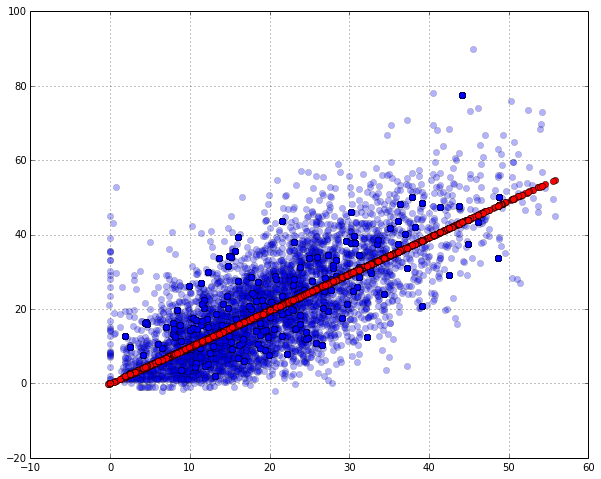

In [386]:
plt.plot(Y[I], X[I], 'o', alpha=.3)
plt.grid()
plt.plot(Y[I], .982*Y[I], 'ro')
plt.show()

### Backtest Lineup Creation

In [76]:
backtest_dates = []
iDate = datetime.date(2016, 3, 9)

d = {}

while iDate <= datetime.date(2016, 3, 9):
    backtest_dates.append(iDate)
    iDate += datetime.timedelta(days=1)
    
cash_lines = pd.read_csv('fd_50-50_cutoffs.csv', index_col=False)
cash_lines.date = [datetime.datetime.strptime(x, '%Y-%m-%d').date() for x in cash_lines.date]
cash_lines.slate = cash_lines.slate.fillna('')
# cash_lines = cash_lines[cash_lines.slate=='']
cash_lines = pd.pivot_table(cash_lines, columns=['date','slate'], values='cash_line', aggfunc=np.mean).T

wins = 0
games = 0
entries = 1

PENALTY = 0
NLINEUPS = 1

NEW_OPTIMIZER = True
# NEW_OPTIMIZER = False

DFS_SITE = 'DP'

winrates = {}
slate_size = {}
for backtest_date in backtest_dates:
    BOUNDS = {
        # LAST_COMMA_FIRST : x,
        'LB' : {
        },
        'UB' : {
        },
        'EQ' : {
            'Smith, Josh': 0,
        },
    }
    
#     SLATE = 'main'
    for SLATE in get_slates(backtest_date, DFS_SITE):
#         try:
#             if SLATE not in cash_lines.loc[backtest_date].index:
#                 continue
#         except KeyError:
#             print 'iter_date',backtest_date,' not found'
#             continue
        try:
            print backtest_date, SLATE
            GAMES = get_slate_games(backtest_date, SLATE, DFS_SITE)
        except:
            print 'slate game error'
            GAMES = []

        TEAM_CONS = {
        }

        try:
            PROJS = pd.read_csv('Projections/fd_%s.csv' % backtest_date, index_col=0)
        except IOError, e:
            try:
                PROJS = pd.read_csv('Projections/nba_%s.csv' % backtest_date, index_col=0)
            except IOError, e2:
                print e2.message
                continue
    #     if 'ADJ' not in PROJS.keys():
    #         PROJS['ADJ'] = PROJS['ADJ_%s'%DFS_SITE]
    #         continue

        PROJS['Proj'] = PROJS['PROJ_%s'%DFS_SITE]
        try:
            PROJS['Salary'] = PROJS['%s_Salary'%DFS_SITE]
            PROJS['Position'] = PROJS['%s_Position'%DFS_SITE]
        except:
            PROJS['Salary'] = PROJS.Salary
            PROJS['Position'] = PROJS.Position
    #     PROJS['Proj'] = scorer.FD.loc[PROJS.index].fillna(0).tolist()
    #     PROJS['Std'] = PROJS.PROJ_HIST_FD_std
        PROJS['Injury Indicator'] = PROJS['Injury Indicator'].fillna('')
        PROJS['Injury Details'] = PROJS['Injury Details'].fillna('')
        PROJS['Status'] = [' - '.join([x,y]) if x != '' else '-' for x,y in zip(PROJS['Injury Indicator'],PROJS['Injury Details'])]
    #     PROJS['ADJ'] *= PROJS['PROJ_MIN']

        PROJS['Own'] = 0.

#         try:
#             tmp = pd.read_csv('Ownerships/nba_fd_du_%s.csv'%backtest_date)
#             tmp['LAST_COMMA_FIRST'] = ['%s, %s' % (' '.join(x.split(' ')[1:]), x.split(' ')[0]) for x in tmp.Name]
#             tmp.LAST_COMMA_FIRST = [dfsutils.COMMA_NAME_CORRECTIONS[x] if x in dfsutils.COMMA_NAME_CORRECTIONS else x for x in tmp.LAST_COMMA_FIRST]
#             for row in tmp.iterrows():
#                 k, row = row
#                 try:
#         #             n = np.nonzero(PROJS.LAST_COMMA_FIRST==row.LAST_COMMA_FIRST)[0][0]
#                     n = PROJS[PROJS.LAST_COMMA_FIRST==row.LAST_COMMA_FIRST].iloc[0].name
#                 except:
#                     print row
#                 PROJS.set_value(n, 'Own', row.Own/100.)
#         except:
#             pass

        input_table = PROJS.copy()
        c = 1
        input_table['PROJ_FD_Var'] = 4*(input_table.PROJ_FGM-input_table.PROJ_FG3M) + 9*input_table.PROJ_FG3M + input_table.PROJ_FTM + 2.25*input_table.PROJ_AST + 4*input_table.PROJ_STL + 4*input_table.PROJ_BLK + input_table.PROJ_TOV
        input_table['PROJ_FD_Std'] = np.sqrt(input_table.PROJ_FD_Var)
        input_table['PROJ_FD_LO'] = input_table.PROJ_FD - c*input_table.PROJ_FD_Std
        input_table['PROJ_FD_HI'] = input_table.PROJ_FD + c*input_table.PROJ_FD_Std

        if GAMES == []:
            GAMES = np.unique(input_table.Game)
        print GAMES
    #     if len(GAMES) < 9:
    #         continue

        input_table = input_table[input_table.PROJ_MIN > 15]
        input_table['TAG'] = ['%s (%s, %s)' % (lcf,p,t) for lcf,p,t in zip(input_table.LAST_COMMA_FIRST, input_table.Position, input_table.Team)]

        input_table = input_table[[x in GAMES for x in input_table.Game]]
        try:
            input_table.Proj = .667*input_table['PROJ_%s'%DFS_SITE] + .333*input_table['PROJ_CEIL_%s'%DFS_SITE]
#             input_table.Proj = input_table.PROJ_FD
        except:
            continue
        input_table = input_table[(~np.isnan(input_table.Proj)) & (~np.isnan(input_table.Salary))]
        input_table['Value'] = input_table.Proj / input_table.Salary * 1000

        scorer = global_stats[global_stats.GAME_DATE == backtest_date].copy().set_index('Player_ID')

#         x = [scorer.loc[pid].MIN>0 if pid in scorer.index else False for pid in input_table.index]
#         input_table = input_table[x]

    #     plus2 = input_table[input_table.ADJ>2].sort('ADJ', ascending=False)[['LAST_COMMA_FIRST',"Position",'Salary','Team','Game','PROJ_FD','PROJ_MIN','ADJ']]
    #     plus2.LAST_COMMA_FIRST = [dfsutils.COMMA_NAME_CORRECTIONS[x] if x in dfsutils.COMMA_NAME_CORRECTIONS else x for x in plus2.LAST_COMMA_FIRST]
    #     print plus2

    #     while True:
    #         player = input('Name a player to lock (q to exit):')
    #         if player == 'q':
    #             break
    #         BOUNDS['EQ'][player] = 0

    #     while True:
    #         player = input('Name a player to omit (q to exit):')
    #         if player == 'q':
    #             break
    #         BOUNDS['EQ'][player] = 0

    #     for lcf in plus2.LAST_COMMA_FIRST:
    #         if lcf not in BOUNDS['EQ']:
    #             BOUNDS['EQ'][lcf] = 1

        if NEW_OPTIMIZER:
#             lo = dfsutils.get_optimizer(input_table, DFS_SITE, penalty=PENALTY)
            lo = dfsutils.get_optimizer(input_table, DFS_SITE)

        CONSTRAINTS = []
        for lcf, bd in BOUNDS['EQ'].iteritems():
            try:
                tmpbdtab = input_table[input_table.LAST_COMMA_FIRST==lcf].iloc[0]
                con_name = '%s (%s, %s)' % (lcf, tmpbdtab.Position, tmpbdtab.Team)
                lo.addPlayerConstraint(con_name, 'eq', bd, con_name)
                CONSTRAINTS.append(con_name)
            except:
                print lcf, 'EQ bound failed'

        freq = {}
        lus = []
        for _ in range(NLINEUPS):
            print 'Starting lineup', _,
            status, lu = lo.solve()
            print 'Finished lineup', _
            if status != 'Optimal':
                print 'Status Warning:', status
                break
            lus.append(lu)
    #         for tag in lu.index:
    #             try:
    #                 freq[tag] += 1
    #             except KeyError:
    #                 freq[tag] = 1
    #             try:
    #                 if freq[tag] == 2:
    #                     lo.addPlayerConstraint(tag, 'eq', 0)
    #             except:
    #                 pass
#             lo.disallowLineup(lu)
    #         vec = [float(x in lu.index.tolist()) for x in input_table.TAG]
    #         lo.addSeriesConstraint(pd.Series(vec, index=input_table.TAG), 'le', 3)

        if status != 'Optimal':
            continue

        for con_name in CONSTRAINTS:
            lo.removeConstraint(con_name)

    #     lus = sorted(lus, key=lambda x: -x.PROJ_FD.sum())
        scores = []
        print backtest_date
    #     print 'Max Score: %.2f' % np.max([scorer.loc[lu.Player_ID].FD.sum() for lu in lus])
        subwins = 0
        subgames = 0
        for lu_num, lu in enumerate(lus):
            print 'Projection: %.2f' % lu['PROJ_%s'%DFS_SITE].sum()
            score = scorer.loc[lu.Player_ID][DFS_SITE].sum()
            scores.append(score)
            print 'Actual: %.2f' % score
            print 'Salary: %d' % lu.Salary.sum()
            try:
                print 'CashLine: %.2f' % cash_lines.loc[backtest_date, SLATE]
    #             subwinsinc = (cash_lines.loc[backtest_date, SLATE] + 5*np.random.randn(entries) <= score).sum()
                subwinsinc = (cash_lines.loc[backtest_date, SLATE] <= score).sum()
                subwins += subwinsinc
                subgamesinc = entries
                subgames += subgamesinc
            except KeyError:
                pass
            tmp = lu.copy()
            tmp[DFS_SITE] = scorer[DFS_SITE].loc[tmp.Player_ID].fillna(0).tolist()
            tmp['MIN'] = scorer.MIN.loc[tmp.Player_ID].fillna(0).tolist()
#             print 'Win%%: %.2f%%' % (100.*subwinsinc/entries)
            print tmp[['Game','Own','Salary','Proj','PROJ_%s'%DFS_SITE,DFS_SITE,'PROJ_MIN','MIN']]#,'Own','ADJ','Status']]
            print 70*'-'
#         print "Win%%: %.2f%%" % (100.*subwins / subgames), 'Proj Corr: %.2f%%' % (100.*proj_corr[backtest_date])
        winrates[backtest_date] = (100.*subwins / subgames)
        slate_size[backtest_date] = len(GAMES)
        wins += subwins
        games += subgames
        d[backtest_date] = scores

print "Win%%: %.2f%%" % (100.*wins / games)

2016-03-09 main
['HOU@PHI', 'NOP@CHA', 'MEM@BOS', 'MIA@MIL', 'DET@DAL', 'NYK@PHX', 'LAC@OKC', 'CLE@SAC', 'UTA@GSW']
Starting lineup 0 Finished lineup 0
2016-03-09
Projection: 361.33
Actual: 357.50
Salary: 299
                                Game  Own  Salary       Proj    PROJ_DP  \
TAG                                                                       
Chalmers, Mario (PG, MEM)    MEM@BOS    0   22.28  32.450520  34.225503   
Harden, James (SG, HOU)      HOU@PHI    0   55.50  58.178636  57.469743   
Gay, Rudy (SF, SAC)          CLE@SAC    0   25.65  33.796320  32.360822   
Covington, Robert (SF, PHI)  HOU@PHI    0   25.48  30.246160  28.977665   
Barnes, Matt (SF, MEM)       MEM@BOS    0   18.27  26.737324  26.486278   
Love, Kevin (PF, CLE)        CLE@SAC    0   29.83  37.901367  35.466021   
Green, JaMychal (PF, MEM)    MEM@BOS    0   16.70  27.176262  30.367129   
Cousins, DeMarcus (C, SAC)   CLE@SAC    0   50.95  51.974973  50.274695   
Howard, Dwight (C, HOU)      HOU@PHI    0

ZeroDivisionError: float division by zero

In [76]:
1.*wins/NLINEUPS, games/NLINEUPS

(44.0, 72)

In [77]:
print "Win%%: %.2f%%" % (100.*wins / games)

Win%: 61.11%


In [78]:
1.-scst.beta.cdf(5./9, 1.*wins/NLINEUPS+.5, 1.*(games-wins)/NLINEUPS+.5)

0.82846537661065156

In [936]:
# lus = sorted(lus, key=lambda x: scorer.loc[x.Player_ID][DFS_SITE].sum())
lu = lus[-1]
tmp = lu.copy()
tmp[DFS_SITE] = scorer[DFS_SITE].loc[tmp.Player_ID].fillna(0).tolist()
tmp['MIN'] = scorer.MIN.loc[tmp.Player_ID].fillna(0).tolist()
print 'Win%%: %.2f%%' % (100.*subwinsinc/entries)
print tmp[['Game','Own','Salary','PROJ_%s'%DFS_SITE,DFS_SITE,'PROJ_MIN','MIN']]#,'Own','ADJ','Status']]
print 70*'-'

Win%: 100.00%
                                  Game  Own  Salary    PROJ_FD    FD  \
TAG                                                                    
Thomas, Isaiah (PG, BOS)       SAC@BOS    0    7800  34.085504  45.3   
Payton, Elfrid (PG, ORL)       ATL@ORL    0    5200  23.272764  35.8   
Oladipo, Victor (SG, ORL)      ATL@ORL    0    6500  31.217892  30.5   
Barton, Will (SG, DEN)         DEN@NYK    0    5900  25.185282  43.7   
Gallinari, Danilo (SF, DEN)    DEN@NYK    0    7100  32.556272  27.3   
Bazemore, Kent (SF, ATL)       ATL@ORL    0    5100  25.333450  34.1   
Porzingis, Kristaps (PF, NYK)  DEN@NYK    0    6400  29.993724  41.6   
Gordon, Aaron (PF, ORL)        ATL@ORL    0    4900  25.788701  44.6   
Cousins, DeMarcus (C, SAC)     SAC@BOS    0   11100  55.217131  43.4   

                                PROJ_MIN  MIN  
TAG                                            
Thomas, Isaiah (PG, BOS)       32.000000   28  
Payton, Elfrid (PG, ORL)       28.642857   33  
O

In [1480]:
date = datetime.date(2016, 2, 11)
scores = d[date]
scores = np.array(sorted(scores, key=lambda x: -x))
scores

array([ 282.4,  258. ,  257.6,  248.8,  246.9,  244.3,  242.8,  241.5,
        240.1,  236.4,  235. ,  233.1,  232.7,  231.4,  231.1,  229.6,
        226. ,  225.7,  220.8,  214.1])

In [956]:
P = [4000.0, 3000.0, 2000.0, 3000.0, 1000.0, 590.0, 750.0, 590.0, 500.0, 590.0, 400.0, 590.0, 300.0, 200.0, 150.0, 100.0, 87.5, 75.0, 65.0, 60.0, 50.0, 45.0, 40.0, 30.0, 28.75, 25.0, 20.0, 17.219999999999999, 15.0, 13.33, 10.0, 7.5999999999999996, 7.0, 6.79, 5.0, 4.4500000000000002, 3.0, 2.7200000000000002, 2.5, 0.88]
L = [355.20999999999998, 355.19999999999999, 355.20999999999998, 355.19999999999999, 353.70999999999998, 353.69999999999999, 353.70999999999998, 353.69999999999999, 353.70999999999998, 353.69999999999999, 353.70999999999998, 353.69999999999999, 351.39999999999998, 350.89999999999998, 348.80000000000001, 348.11000000000001, 348.10000000000002, 342.90999999999997, 342.89999999999998, 342.69999999999999, 341.70999999999998, 341.69999999999999, 340.5, 339.11000000000001, 339.10000000000002, 337.80000000000001, 335.81, 335.80000000000001, 333.61000000000001, 333.60000000000002, 329.81, 329.80000000000001, 326.81, 326.80000000000001, 321.81, 321.80000000000001, 315.40999999999997, 315.39999999999998, 301.50999999999999, 301.5]

In [957]:
pnl = -NLINEUPS
for i in range(len(L)-1):
    pnl += P[i]*(sum(scores>=L[i])-(i>0)*sum(scores>=L[i-1]))
pnl

925.94

In [1441]:
-20 + 

-12

#### My projections

In [952]:
dates = [datetime.date(2016, 1, 24)+datetime.timedelta(days=k) for k in range(15)]
for date in dates:
    print date, len(get_slate_games(date, 'main', 'FD'))

2016-01-24 4
2016-01-25 9
2016-01-26 8
2016-01-27 8
2016-01-28 6
2016-01-29 9
2016-01-30 5
2016-01-31 6
2016-02-01 9
2016-02-02 5
2016-02-03 11
2016-02-04 4
2016-02-05 10
2016-02-06 9
2016-02-07 4


In [1481]:
d = {
    11 : -16,
    10 : 35,
     9 : 7.46,
     8 : -18,
     7 : 78,
     6 : -12,
     5 : -16,
     4 : 21,
     3 : 4,
     2 : -20,
     1 : -16,
    31 : -4,
    30 : -20,
    29 : -20,
    28 : 65,
    27 : 21,
    26 : 37,
    25 : 4,
    24 : -20,
    }
pnl = sum(d.values())
roi = pnl / (20.*len(d))
pnl, roi

(110.46000000000001, 0.2906842105263158)

#### Using Ownership Model

In [1482]:
d = {
    11 : -18,
    10 : -12,
     9 : -16,
     8 : -3.11,
     7 : -12.5,
     6 : 68.5,
     5 : -20,
     4 : -2,
     3 : 28,
     2 : -14,
     1 : -12,
    31 : -20,
    30 : -7.5,
    29 : 9,
    28 : 879,
    27 : 55,
    26 : 4,
    25 : -1,
    24 : -12,
    23 : 43,
    22 : -15,
    21 : 114,
    20 : 3,
    19 : 8,
    18 : -7.5,
}
pnl = sum(d.values())
roi = pnl / (20.*len(d))
pnl, roi

(1038.8899999999999, 2.0777799999999997)

In [44]:
table = pd.read_csv('/Users/andingo/Downloads/andingo-MyGames-2016-02-23 17-22-06.csv')
table['Buy-In'] = [0 if type(x) != str else float(x[1:]) for x in table['Buy-In']]
table['Prize'] = [0 if type(x) != str else float(x[1:]) for x in table['Prize']]
table

,Game Name,Buy-In,My Score,Opponent Score,My Place,Num. Opponents,Opponent (2 plr games only),Prize,Sport,Date Played,Game Type
0,$1 BIG NBA DU (Multi-Entry),1.0,291.75,339.25,25,111,NaN,2.00,NBA,02/22/16,SALARY
1,$1 BIG NBA DU (Multi-Entry),1.0,291.75,339.25,25,111,NaN,2.00,NBA,02/22/16,SALARY
2,$1 BIG NBA DU (Multi-Entry),1.0,291.75,339.25,25,111,NaN,2.00,NBA,02/22/16,SALARY
3,$1 BIG NBA DU (Multi-Entry),1.0,291.75,339.25,25,111,NaN,2.00,NBA,02/22/16,SALARY
4,$1 BIG NBA DU (Multi-Entry),1.0,291.75,339.25,25,111,NaN,2.00,NBA,02/22/16,SALARY
5,$1 BIG NBA DU (Multi-Entry),1.0,291.75,339.25,25,111,NaN,2.00,NBA,02/22/16,SALARY
6,$1 BIG NBA DU (Multi-Entry),1.0,291.75,339.25,25,111,NaN,2.00,NBA,02/22/16,SALARY
7,$1 BIG NBA DU (Multi-Entry),1.0,291.75,339.25,25,111,NaN,2.00,NBA,02/22/16,SALARY
8,$1 BIG NBA DU (Multi-Entry),1.0,291.75,339.25,25,111,NaN,2.00,NBA,02/22/16,SALARY
9,$5.5 BIG NBA 50/50 (Multi-Entry),5.5,291.75,337.50,12,40,NaN,10.00,NBA,02/22/16,SALARY
